In [99]:
### Benjamin Tollison ###
import sympy as sp
from IPython.display import display, Math, Latex
from sympy.solvers.solveset import linsolve
from sympy.solvers.pde import pdsolve
from sympy import  lambdify, Matrix,sin,cos, sinh, cosh, exp, pi, symbols, integrate, Function, Eq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)

In [100]:
# Newton method for Eccentric anomoly
# part a
e = 0.5
mean_anomoly = np.pi/4
f = lambda E: E - e*np.sin(E) - mean_anomoly
Delta_k = lambda E: f(E)/(1-e*np.cos(E))
step_size = lambda E: np.linalg.norm(Delta_k(E))
true_anomoly = lambda E: 2*np.arctan2(np.sqrt(1+e**2)*np.tan(E/2),np.sqrt(1-e**2))
E_i = np.pi/4
tolerance = 1e-8
Newton_method_data = {'function error':[],'E_k':[],'step size':[],'f_k':[]}
while f(E_i) > tolerance or f(E_i) < -tolerance:
  Newton_method_data['function error'].append(f(E_i))
  Newton_method_data['E_k'].append(E_i)
  Newton_method_data['step size'].append(step_size(E_i))
  Newton_method_data['f_k'].append(true_anomoly(E_i))
  E_i = E_i - (f(E_i) / (1-e*np.cos(E_i)))
pd.DataFrame(Newton_method_data)

,function error,E_k,step size,f_k
0,-3.535534e-01,0.785398,5.469182e-01,0.982115
1,6.106908e-02,1.332316,6.924819e-02,1.585435
2,1.157898e-03,1.263068,1.364556e-03,1.513537
3,4.435719e-07,1.261704,5.231400e-07,1.512107


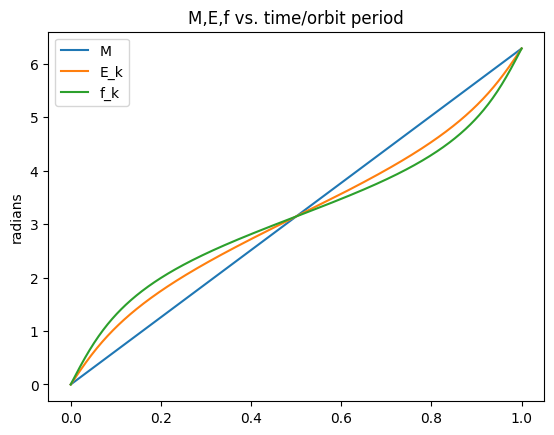

,M,E_i,f_k
0,0.000000,0.000000,0.000000
1,0.012566,0.025130,0.032442
2,0.025133,0.050244,0.064856
3,0.037699,0.075327,0.097216
4,0.050265,0.100363,0.129495
...,...,...,...
496,6.232920,6.182823,6.153690
497,6.245486,6.207858,6.185969
498,6.258053,6.232941,6.218329
499,6.270619,6.258055,6.250744


In [101]:
time = np.linspace(0,1,501)
M = lambda t: 2*np.pi*t
fractional_revolution = {'M':[],'E_i':[],'f_k':[]}
for t in time:
  fractional_revolution['M'].append(M(t))
  mean_anomoly = M(t)
  E_i = M(t)
  while f(E_i) > tolerance or f(E_i) < -tolerance:
    E_i = E_i - (f(E_i) / (1-e*np.cos(E_i)))
  fractional_revolution['E_i'].append(E_i)
  if true_anomoly(E_i) >= 0:
    fractional_revolution['f_k'].append(true_anomoly(E_i))
  else:
    fractional_revolution['f_k'].append(true_anomoly(E_i)+2*np.pi)
plt.plot(time,fractional_revolution['M'],label='M')
plt.plot(time,fractional_revolution['E_i'],label='E_k')
plt.plot(time,fractional_revolution['f_k'],label='f_k')
plt.legend()
plt.title('M,E,f vs. time/orbit period')
plt.ylabel('radians')
plt.show()
pd.DataFrame(fractional_revolution)

In [118]:
# Problem 2
mu = 398600.435507
r0 = np.array([944.189,10001.1,794.345])
v0 = np.array([-4.64354,1.26599,3.30258])
h = np.cross(v0,np.cross(r0,v0))/mu - r0/np.linalg.norm(r0)
specific_mechanical_energy = np.linalg.norm(v0)**2/2 - mu/np.linalg.norm(r0)
a = -mu/(2*specific_mechanical_energy)
displayEquations('a',a)
e = np.cross(v0,h)/mu - r0/np.linalg.norm(r0)
displayEquations('e',e)
displayEquations('h',h)
e_hat = e/np.linalg.norm(e)
h_hat = h/np.linalg.norm(h)
p_hat = np.cross(h_hat,e_hat)
inclination = np.arccos(h_hat[2])
displayEquations('i',inclination*180/np.pi)
argument_of_periapsis = np.arctan2(e_hat[2],p_hat[2])
displayEquations(symbols('\\omega'),argument_of_periapsis)
longitude_of_ascending_node = np.arctan2(h_hat[0],-h_hat[1])
displayEquations(symbols('\\Omega'),longitude_of_ascending_node)
f0 = np.arccos(np.dot(e,r0)/(np.linalg.norm(e)*np.linalg.norm(r0)))
orbit_period = 2*np.pi/np.sqrt(mu) * a**(3/2)
e_norm = np.linalg.norm(e)
kepler_equation = lambda E: np.sqrt(a**3/mu)*(E-e_norm*np.sin(E)) - 3600
E_k = np.pi/4
while kepler_equation(E_k) > 1e-8 or kepler_equation(E_k) < -1e-8:
  E_k = E_k - kepler_equation(E_k)/(np.sqrt(a**3/mu)-e_norm*np.cos(E_k))
true_anomoly = 2*np.arctan2(np.sqrt(1+e**2)*np.tan(E_k/2),np.sqrt(1-e**2))
displayEquations(symbols('\\Delta_f'),true_anomoly[0])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [103]:
def Orbit_ODE(time:float(),x_vector,gravitational_parameter:float(),dummy_variable):
  dot_r = x_vector[3:6]
  dot_v = (-gravitational_parameter/(np.linalg.norm(x_vector[0:3]))**3) * x_vector[0:3]
  dot_x = np.hstack((dot_r,dot_v))
  return dot_x
def PlotEquationOfMotionInPerifocal(postion_vector,velocity_vector,label:str):
  combined_vector = np.zeros(6)
  for i in range(3):
    combined_vector[i], combined_vector[i+3] = postion_vector[i], velocity_vector[i]
  numerical_solution = scipy.integrate.solve_ivp(Orbit_ODE,(0,orbit_period),combined_vector,method='RK45',args=(mu,2),rtol=1e-12,atol=1e-12)
  x,y,z = numerical_solution.y[0],numerical_solution.y[1],numerical_solution.y[2]
  r_numerical = np.zeros((len(x),3))
  x_perifocal = np.zeros(len(x))
  y_perifocal = np.zeros(len(x))
  z_perifocal = np.zeros(len(x))
  for i in range(len(x)):
    r_numerical[i] = np.array([x[i],y[i],z[i]])
    x_perifocal[i] = np.dot(r_numerical[i],e_hat)
    y_perifocal[i] = np.dot(r_numerical[i],p_hat)
    z_perifocal[i] = np.dot(r_numerical[i],h_hat)
    if z_perifocal[i] != 0:
      print('z != 0')
  plt.plot(x_perifocal,y_perifocal,label=label)
  plt.axis('equal')
  return None

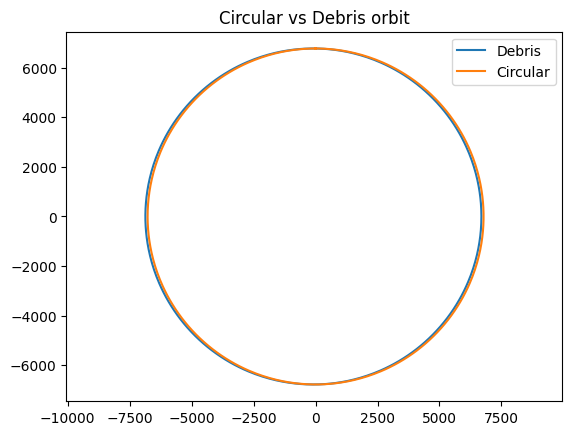

In [104]:
# problem 3
mu = 398600.435507
r_cs = np.array([400+6378.1365,0,0])
v_cs = np.array([0,np.sqrt(mu/np.linalg.norm(r_cs)),0])
v_obj = np.array([0.1,np.sqrt(mu/np.linalg.norm(r_cs)),0])
a_obj = -mu/(np.linalg.norm(v_obj)**2 - (2*mu)/np.linalg.norm(r_cs))
h = np.cross(r_cs,v_obj)
e_obj = np.cross(v_obj,h) /mu - r_cs/np.linalg.norm(r_cs)
r_obj = lambda f: (a_obj*(1-np.linalg.norm(e_obj)**2))/(1+np.linalg.norm(e_obj)*np.cos(f))
p_obj = np.cross(h,e_obj)
e_hat = e_obj/np.linalg.norm(e_obj)
h_hat = h/np.linalg.norm(h)
p_hat = np.cross(h_hat,e_hat)
true_anomoly_list = np.linspace(0,2*np.pi,100)
orbit_period = 2*np.pi/np.sqrt(mu) * a_obj**(3/2)
obj_dict = {'x':[],'y':[]}
plt.title('Circular vs Debris orbit')
PlotEquationOfMotionInPerifocal(r_cs,v_obj,'Debris')
PlotEquationOfMotionInPerifocal(r_cs,v_cs,'Circular')
plt.legend()
plt.show()

In [105]:
# problem 4
r_0 = np.array([-2574.9533,4267.0671,4431.5026])
r = np.array([2700.6738,-4303.5378,-4358.2499])
p = 6681.571
f = np.arccos(np.dot(r,r_0) / (np.linalg.norm(r)*np.linalg.norm(r_0)))
print(f)
F = 1 - (np.linalg.norm(r)/p)*(1-np.cos(f))
G =  ((np.linalg.norm(r)*np.linalg.norm(r_0))/np.sqrt(mu*p)) * np.sin(f)
v_0 = (r-F*r_0) / G
e = np.cross(np.cross(v_0,r_0),v_0)/mu - r_0/np.linalg.norm(r_0)
a = p/(1-np.linalg.norm(e)**2)
E = 2*np.arctan2(np.sqrt(1-np.linalg.norm(e))*np.tan(f/2),np.sqrt(1+np.linalg.norm(e)))
delta_t = np.sqrt(a**3/mu)*(E-np.linalg.norm(e)*np.sin(E))
print(delta_t)
# checking negative angle
f = -f
F = 1 - (np.linalg.norm(r)/p)*(1-np.cos(f))
G =  ((np.linalg.norm(r)*np.linalg.norm(r_0))/np.sqrt(mu*p)) * np.sin(f)
v_0 = (r-F*r_0) / G
e = np.cross(np.cross(v_0,r_0),v_0)/mu - r_0/np.linalg.norm(r_0)
a = p/(1-np.linalg.norm(e)**2)
E = 2*np.arctan2(np.sqrt(1-np.linalg.norm(e))*np.tan(f/2),np.sqrt(1+np.linalg.norm(e)))
delta_t = np.sqrt(a**3/mu)*(E-np.linalg.norm(e)*np.sin(E))
print(delta_t)

3.1194512157322585
2698.461919860547
-2698.461919860547
